In [101]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/swatdataset/SWaT_Dataset_Attack_v0.csv
/kaggle/input/swatdataset/SWaT_Dataset_Normal_v1.csv
/kaggle/input/statsd-swat/statsd_swat.csv


In [102]:
import random
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.autograd import Variable
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import logging
handler=logging.basicConfig(level=logging.INFO)
lgr = logging.getLogger(__name__)

#Utilisation des GPUs
#use_cuda = torch.cuda.is_available()
use_cuda = False

torch.manual_seed(0)

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor


from IPython.display import Image

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.spatial.distance import pdist, squareform #scipy spatial distance
import sklearn as sk
import sklearn.metrics.pairwise
import matplotlib.pyplot as plt
import os



from sklearn import preprocessing
import sklearn.metrics
import sklearn.metrics.pairwise
import matplotlib.pyplot as plt
def recurrence_plot(s, eps=None, steps=None):
    if eps==None: eps=0.1
    if steps==None: steps=10
    d = sklearn.metrics.pairwise.pairwise_distances(s)
    d = np.floor(d / eps)
    d[d > steps] = steps
    return d

# =================================

# Explore dataset

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

df_total= pd.read_csv("../input/swatdataset/SWaT_Dataset_Normal_v1.csv")[0:10000]
df_total = df_total.drop(["Timestamp" , "Normal/Attack" ], axis = 1)

df_total.shape
#df_total.head(2)

(10000, 51)

In [104]:
# Transform all columns into float64
for i in list(df_total): 
    df_total[i]=df_total[i].apply(lambda x: str(x).replace("," , "."))
df_total = df_total.astype(float)

In [105]:
# Normalizing
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = df_total.values
x_scaled = min_max_scaler.fit_transform(x)
df_total = pd.DataFrame(x_scaled)
df_total.head(3)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.015418,0.5,0.0,0.0,0.017471,0.080852,0.0,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.015746,0.5,0.0,0.0,0.017471,0.080852,0.0,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
2,0.0,0.016074,0.5,0.0,0.0,0.017471,0.080852,0.0,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


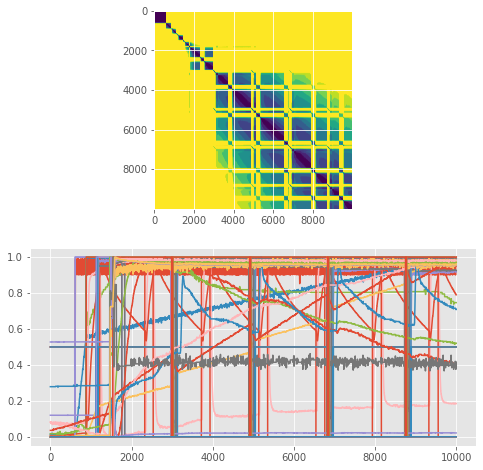

In [106]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(2, 1, 1)
ax.axis('on')
ax.imshow(recurrence_plot(df_total))
ax = fig.add_subplot(2, 1, 2)
ax.axis('on')
ax.plot(df_total)

# ================================
# ================================

# The convolutional auto-encoder <a name="CAE"></a>

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

df_total= pd.read_csv("../input/swatdataset/SWaT_Dataset_Normal_v1.csv")[1000:5000]
df_total = df_total.drop(["Timestamp" , "Normal/Attack" ], axis = 1)

df= pd.read_csv('../input/swatdataset/SWaT_Dataset_Normal_v1.csv')[6000:10000]
df = df.drop(["Timestamp" , "Normal/Attack" ], axis = 1)


df_test= pd.read_csv('../input/swatdataset/SWaT_Dataset_Normal_v1.csv')[12000:18000]
df_test = df_test.drop(["Timestamp" , "Normal/Attack" ], axis = 1)


In [108]:
# Transform all columns into float64
for i in list(df_total): 
    df_total[i]=df_total[i].apply(lambda x: str(x).replace("," , "."))
df_total = df_total.astype(float)

#print(df)

for i in list(df): 
    df[i]=df[i].apply(lambda x: str(x).replace("," , "."))
df = df.astype(float)


for i in list(df_test): 
    df_test[i]=df_test[i].apply(lambda x: str(x).replace("," , "."))
df_test = df_test.astype(float)

In [109]:
df_total = df_total.iloc[1:].dropna()
x = df_total.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalize = pd.DataFrame(x_scaled)

We cut in time windows of size 900 and step 5. 

In [110]:
n = 200
k = 5
list_df = np.array([df_normalize[i:i+n].values.tolist() for i in range(0,df_normalize.shape[0]-n,k)] ,  dtype=np.float64)

In [111]:
import sklearn.metrics
import os
from pathlib import Path

Path("./Data/train_img").mkdir(parents=True, exist_ok=True)
Path("./Data/test_img").mkdir(parents=True, exist_ok=True)

#if not os.path.exists('./img'):
#    os.makedirs('./img')


filenames_train = []

j=0
for i in list_df: 
    j+=1
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.axis('off')
    ax.imshow(recurrence_plot(i))
    fig.savefig('./Data/train_img/img_'+str(j)+'.png')   # save the figure to file
    filenames_train.append('./Data/train_img/img_'+str(j)+'.png')
    plt.close(fig)
    
    
    
filenames_test = []
jj=0
for i in list_df: 
    jj+=1
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.axis('off')
    ax.imshow(recurrence_plot(i))
    fig.savefig('./Data/test_img/img_'+str(jj)+'.png')   # save the figure to file
    filenames_test.append('./Data/test_img/img_'+str(jj)+'.png')
    plt.close(fig)


In [112]:
from skimage.io import imread 
from skimage.transform import resize
from tqdm import tqdm
import sklearn.metrics
import os
from pathlib import Path

train_img = []
for img_name in tqdm(range(100,700)):
    # defining the image path
    image_path = './Data/train_img/img_'+ str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    img = resize(img, (100, 100))
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # normalizing the pixel values
    img /= 255.0
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)

train_x.shape

100%|██████████| 600/600 [00:36<00:00, 16.64it/s]


(600, 100, 100)

In [113]:
test_img = []
for img_name in tqdm(range(list_df.shape[0]-700,list_df.shape[0])):
    # defining the image path
    image_path = './Data/test_img/img_'+ str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    img = resize(img, (100, 100))
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # normalizing the pixel values
    img /= 255.0
    # appending the image into the list
    test_img.append(img)

# converting the list to numpy array
test_x = np.array(test_img)

test_x.shape

100%|██████████| 700/700 [00:42<00:00, 16.62it/s]


(700, 100, 100)

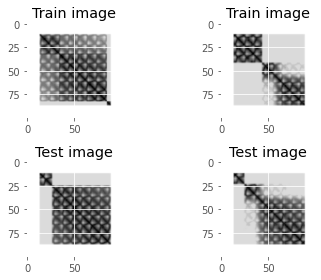

In [114]:
fig, axes = plt.subplots(nrows=2, ncols=2)

ax = axes.ravel()

ax[0].imshow(train_img[15], cmap='gray')
ax[0].set_title("Train image")

ax[1].imshow(train_img[150], cmap='gray')
ax[1].set_title("Train image")

ax[2].imshow(test_img[100], cmap='gray')
ax[2].set_title("Test image")

ax[3].imshow(test_img[200], cmap='gray')
ax[3].set_title("Test image")


plt.tight_layout()
plt.show()

# ==========================
# ==========================
# ==========================

In [115]:
import pandas as pd
import matplotlib.pyplot as plt

df_total_diff= pd.read_csv("../input/statsd-swat/statsd_swat.csv")[0:4000]
#df_total_diff = df_total_attack.drop(["Timestamp", "Normal/Attack" ], axis = 1)
df_total_diff.shape
df_total_diff.head(2)


,CN2,ESCO,SURLAG,RCHRG_DP,GWQMN,GW_REVAP,REVAPMN,GW_DELAY,ALPHA_BF,SOL_K,...,mth.spring.kge,mth.sum.kge,mth.autumn.kge,mth.winter.kge,aug.kge,spring.kge,sum.kge,autumn.kge,winter.kge,row
0,0.127363,0.150558,9.208940,0.486105,1711.713386,0.116649,67.390320,14.557365,0.084193,0.119292,...,0.800289,0.583088,0.418816,0.585225,-1.122331,0.700291,0.599949,0.495543,0.284555,324
1,-0.181685,0.646410,2.718601,0.070882,4544.884834,0.172495,130.208871,76.427807,0.053084,-0.098834,...,0.852019,0.681294,0.665652,0.517511,-1.339486,0.658159,0.661118,0.484076,0.197628,146


In [116]:
# Transform all columns into float64
for i in list(df_total_diff): 
    df_total_diff[i]=df_total_diff[i].apply(lambda x: str(x).replace("," , "."))
df_total_diff = df_total_diff.astype(float)

#print(df_total_attack)

In [117]:
df_total_diff = df_total_diff.iloc[1:].dropna()
x = df_total_diff.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalize_diff = pd.DataFrame(x_scaled)

In [118]:
n = 200
k = 5
list_df_diff = np.array([df_normalize_diff[i:i+n].values.tolist() for i in range(0,df_normalize_diff.shape[0]-n,k)] ,  dtype=np.float64)

In [119]:
import sklearn.metrics
import os
from pathlib import Path


Path("./Data/test_img_diff").mkdir(parents=True, exist_ok=True)

   
filenames_test_diff = []
jjj=0
for i in list_df_diff: 
    jjj+=1
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.axis('off')
    ax.imshow(recurrence_plot(i))
    fig.savefig('./Data/test_img_diff/img_'+str(jjj)+'.png')   # save the figure to file
    filenames_test_diff.append('./Data/test_img_diff/img_'+str(jjj)+'.png')
    plt.close(fig)


In [120]:
test_img_diff = []
#for img_name in tqdm(range(100,700)):
for img_name in tqdm(range(list_df.shape[0]-700,list_df_diff.shape[0])):
    # defining the image path
    image_path = './Data/test_img_diff/img_'+ str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    img = resize(img, (100, 100))
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # normalizing the pixel values
    img /= 255.0
    # appending the image into the list
    test_img_diff.append(img)

# converting the list to numpy array
test_x_diff = np.array(test_img_diff)

test_x_diff.shape

100%|██████████| 100/100 [00:05<00:00, 18.72it/s]


(100, 100, 100)

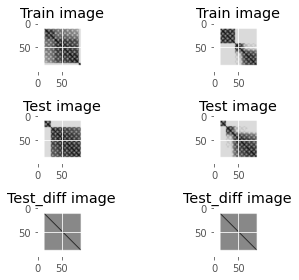

In [121]:
fig, axes = plt.subplots(nrows=3, ncols=2)

ax = axes.ravel()

ax[0].imshow(train_img[15], cmap='gray')
ax[0].set_title("Train image")

ax[1].imshow(train_img[150], cmap='gray')
ax[1].set_title("Train image")

ax[2].imshow(test_img[100], cmap='gray')
ax[2].set_title("Test image")

ax[3].imshow(test_img[200], cmap='gray')
ax[3].set_title("Test image")


ax[4].imshow(test_img_diff[10], cmap='gray')
ax[4].set_title("Test_diff image")

ax[5].imshow(test_img_diff[50], cmap='gray')
ax[5].set_title("Test_diff image")


plt.tight_layout()
plt.show()

# =======================
# =======================
# ==========================

In [122]:
train_x = train_x.reshape(train_x.shape[0], 1, 100, 100)
train_x = torch.from_numpy(train_x)


test_x = test_x.reshape(test_x.shape[0], 1, 100, 100)
test_x = torch.from_numpy(test_x)


test_x_diff = test_x_diff.reshape(test_x_diff.shape[0], 1, 100, 100)
test_x_diff = torch.from_numpy(test_x_diff)

In [123]:
import torch.nn as nn
import torch.nn.functional as F


# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1) #gray 
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        ## decoder layers ##
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)#gray


    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
                
        return x




In [124]:
# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [125]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
# defining the loss function
criterion = nn.MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    

In [126]:
import torch.utils.data

num_workers = 0
# how many samples per batch to load
batch_size = 2
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_x, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_x, batch_size=batch_size, num_workers=num_workers)
test_loader_diff = torch.utils.data.DataLoader(test_x_diff, batch_size=batch_size, num_workers=num_workers)

In [127]:
n_epochs = 101

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        images = data.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    if(epoch % 10 == 1):
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
            ))

Epoch: 1 	Training Loss: 0.025183
Epoch: 11 	Training Loss: 0.000003
Epoch: 21 	Training Loss: 0.000003
Epoch: 31 	Training Loss: 0.000002
Epoch: 41 	Training Loss: 0.000001
Epoch: 51 	Training Loss: 0.000001
Epoch: 61 	Training Loss: 0.000000
Epoch: 71 	Training Loss: 0.000000
Epoch: 81 	Training Loss: 0.000000
Epoch: 91 	Training Loss: 0.000000
Epoch: 101 	Training Loss: 0.000000


# =================
# ====== Test =====

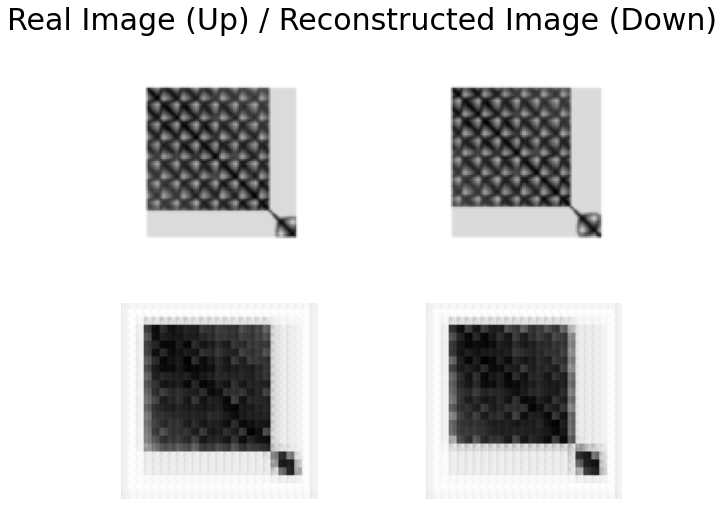

In [128]:
dataiter = iter(test_loader)
#dataiter = iter(test_loader_diff)

images= dataiter.next()
output = model(images.cuda())
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 100, 100)
# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()


#plot the original images and semulated forms of them
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,8))
fig.suptitle("Real Image (Up) / Reconstructed Image (Down)", fontsize=30)
# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img[0]), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        

In [149]:
# calculate loss
losses1 = []
images_test1 = []
losses2 = []
images_test2 = []

losses3 = []
images_test3 = []

for data in train_loader:
        images = data.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        losses1.append(criterion(outputs, images).item())
        images_test1.append(images.view(batch_size, 1, 100, 100).detach().cpu().numpy())
        
        

for data in test_loader:
        images = data.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        losses2.append(criterion(outputs, images).item())
        images_test2.append(images.view(batch_size, 1, 100, 100).detach().cpu().numpy())
        
for data in test_loader_diff:
        images = data.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        losses3.append(criterion(outputs, images).item())
        images_test3.append(images.view(batch_size, 1, 100, 100).detach().cpu().numpy())
        


Text(0.5, 1.0, 'Time-series')

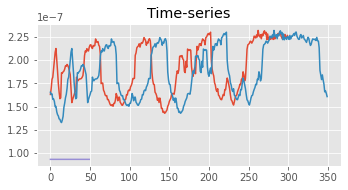

In [151]:
        
# Plot --------------------------        
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(4, 2, 2)
ax.axis('on')
ax.plot(losses1)
ax.plot(losses2)
ax.plot(losses3)
ax.set_title('Loss')
ax.set_title('Time-series')

9.294556946315424e-08

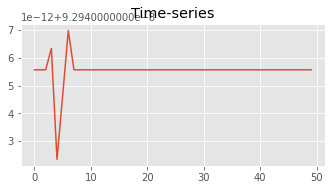

In [154]:
# Plot --------------------------        
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(4, 2, 2)
ax.axis('on')
#ax.plot(losses1)
#ax.plot(losses2)
ax.plot(losses3)
ax.set_title('Loss')
ax.set_title('Time-series')


In [160]:
print("Loss Comparision")
print('traion from normal:',losses1[1])
print('test from normal:',losses2[1])
print('test from other normal dataset:',losses3[1])

Loss Comparision
traion from normal: 1.6961543281013292e-07
test from normal: 1.6306607619753777e-07
test from other normal dataset: 9.294556946315424e-08


Adaptive/Automatic/Intelligent choice of threshold in detecting anomaly.

# =================================
# =================================
# =================================
# =================================
# =================================
# =================================
# =================================
# =================================
# =================================
# =================================